## Microbusiness Density Forecasting using Statistical Models

#### Univariate models like ARIMA or prophet can be used to forecasting Microbusiness Density provided we convert the dataset into a univariate data, i.e, data with only time-series variable and target variable

### Install Packages

In [16]:
import warnings
warnings.filterwarnings('ignore')

import pip

def import_or_install(package):
    try:
        __import__(package)
    except ImportError:
        pip.main(['install','-q', package])  

packages = ["numpy", "pystan", "statsmodels", "pandas", "prophet", "seaborn","plotly", "pmdarima", "nbformat"] 

for package in packages:
    import_or_install(package)



### Import Required Libraries

In [17]:
# Import required libraries
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
pio.templates.default = "none"

### Read Data

In [18]:
df_train = pd.read_csv("../common/data/train.csv")
df_test = pd.read_csv("../common/data/test.csv")

### EDA


* The essential step needed to perform forecasting using univariate models is populating the "time-series" datatype object from the string representation of date column. 
* We will group the density values per month across all the counties so that we will endup with 39 rows of data where each row corresponds to the Microbusiness Density for a given month. 


In [19]:
# Convert to datetime
df_train['first_day_of_month'] = pd.to_datetime(df_train['first_day_of_month'], format = "%Y-%m-%d")

In [20]:
# Rename the columns
df_renamed = df_train[['first_day_of_month', 'microbusiness_density']]
df_renamed.rename(columns = {'first_day_of_month':'date', 'microbusiness_density':'density',}, inplace = True)
df_renamed.head()

# Group by month
df_grouped = df_renamed.groupby('date')['density'].mean().reset_index()
df_grouped.head()

,date,density
0,2019-08-01,3.749621
1,2019-09-01,3.696846
2,2019-10-01,3.778263
3,2019-11-01,3.722510
4,2019-12-01,3.717284


Text(0.5, 1.0, 'Monthly Microbusiness Density')

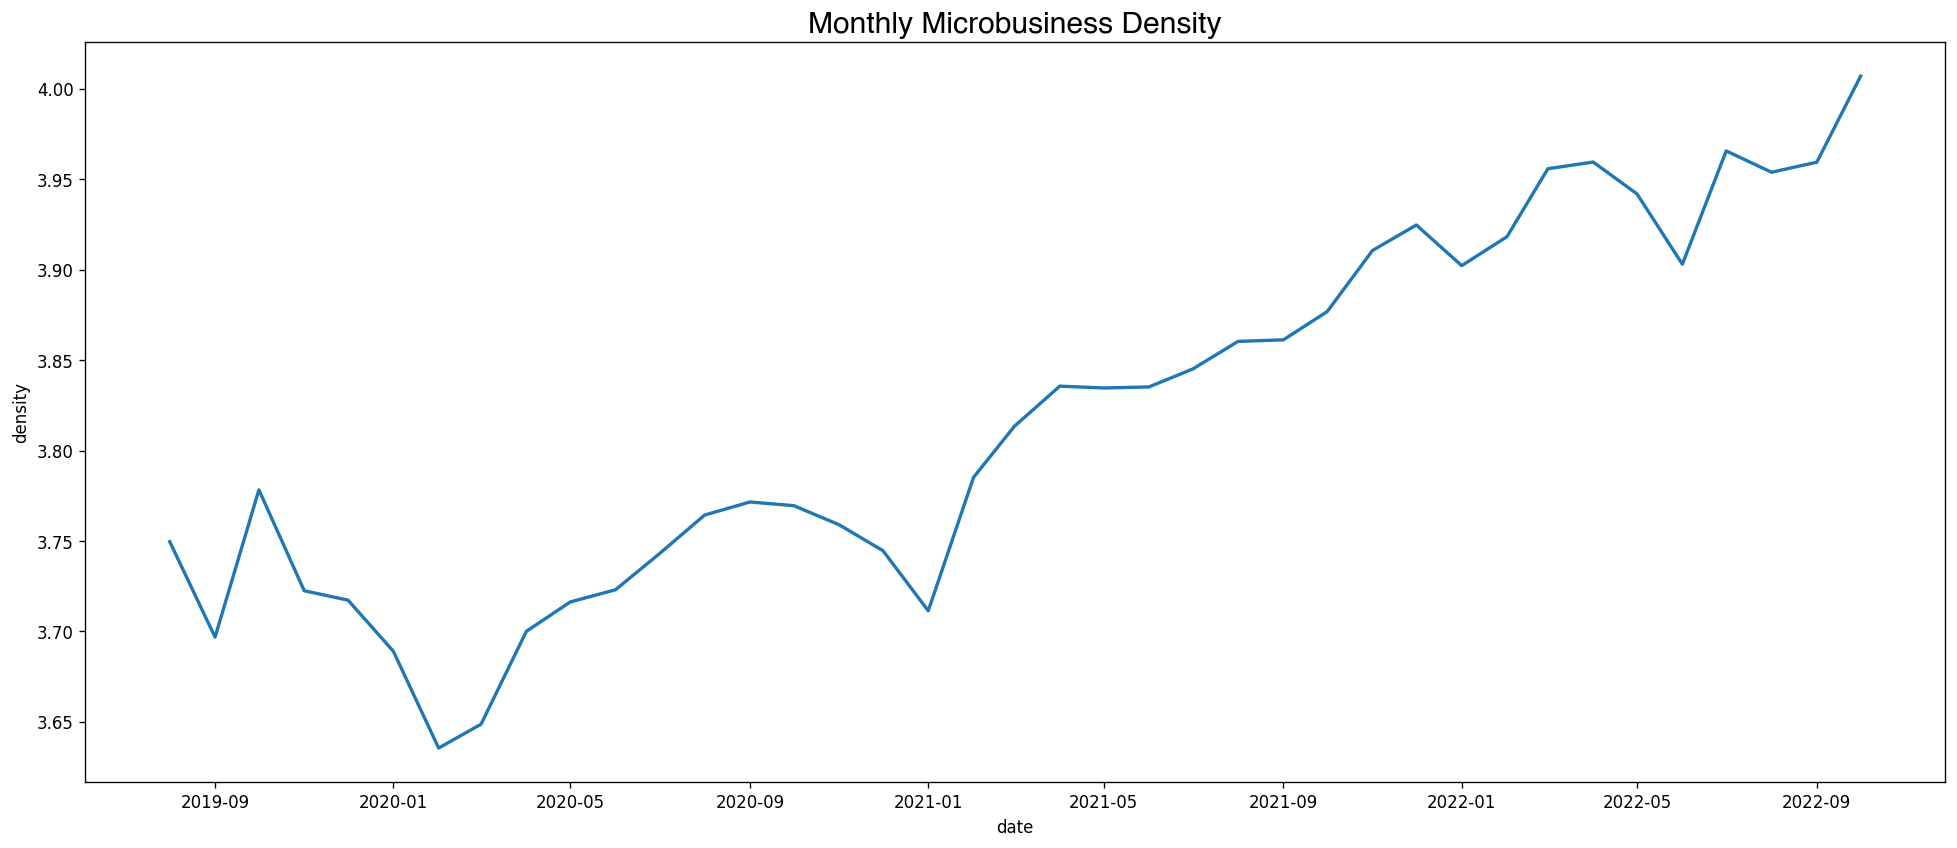

In [21]:
# Plot the graph
fig = plt.figure(figsize = (20, 8))
sns.lineplot(x = df_grouped['date'], y= df_grouped['density'], linewidth=2, )
plt.title("Monthly Microbusiness Density",
          fontsize = 18,
          fontweight = 'bold',
          fontfamily = 'Helvetica',
          loc = 'center')


*Data doesn't appear to be Seasonal**

#### Running the Statistical Model

**Approach 1:** We will train an ARIMA model on the grouped data and try to forecast the Microbusiness Density for the upcoming months

We will use a library called Auto-ARIMA to perform hyperparameter tuning and determine the "p", "d", "q" variables that determine an ARIMA model. In an ARIMA (AutoRegressive Integrated Moving Average) model, "p", "d", and "q" are parameters that represent different components of the model:

* "p" is the order of the Autoregression(AR) term. It represents the number of lagged values of the time series used to explain the current value.

* "d" is the degree of differencing(I). It represents the number of times the time series has been difference to make it stationary.

* "q" is the order of the moving average term (MA). It represents the number of lagged forecast errors used to explain the current value.

The combination of these three parameters (p, d, q) defines the structure of the ARIMA model, which is used to make predictions about future values of the time series based on past values.

**Let's run the ADF test to determine if the data is stationary**

Augmented Dicky Fuller Test

In [22]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_grouped['density'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.176712
p-value: 0.941241
Critical Values:
	1%: -3.616
	5%: -2.941
	10%: -2.609


Here we can see that the p-value is more than 0.05 this means our null hypothesis will not be rejected and we will take this series as non-stationary.  


We need to determine the differencing term. The simplest way to do this is differencing the data directly using Pandas for different orders and plot the data

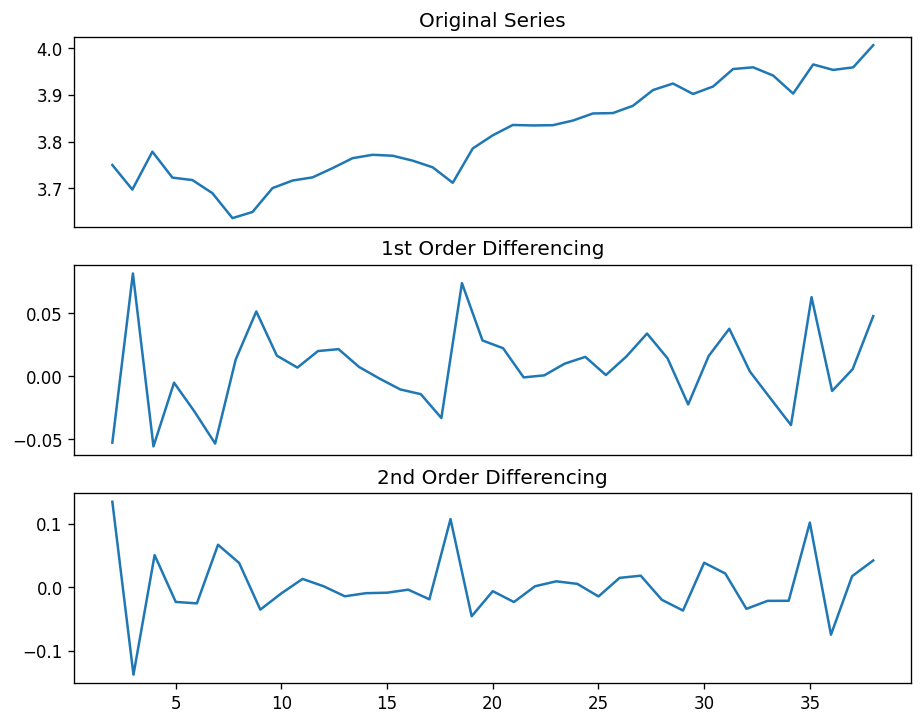

In [23]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(df_grouped.density); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(df_grouped.density.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(df_grouped.density.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

The first order differencing appears to be stationary, so d can be set as 1

There are methods to determine "p" and "q" but we will use a popular framework called Auto-ARIMA to select the best p and q values.

In [24]:
model_fit = auto_arima(df_grouped['density'],
                       test='adf',
                       d=1,
                       D=1,
                       start_p=0,
                       start_q=0,
                       max_order=None,                       
                       max_p=10,
                       max_q=10,
                       max_d=5,
                       max_P=10,
                       max_Q=10,
                       max_D=10,
                       maxiter = 50,
                       alpha = 0.05,
                       trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True
                      )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-149.745, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-149.279, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-149.488, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-150.080, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-149.227, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.119 seconds


The p, d, q values are 0, 1 and 0 respectively.

<AxesSubplot: >

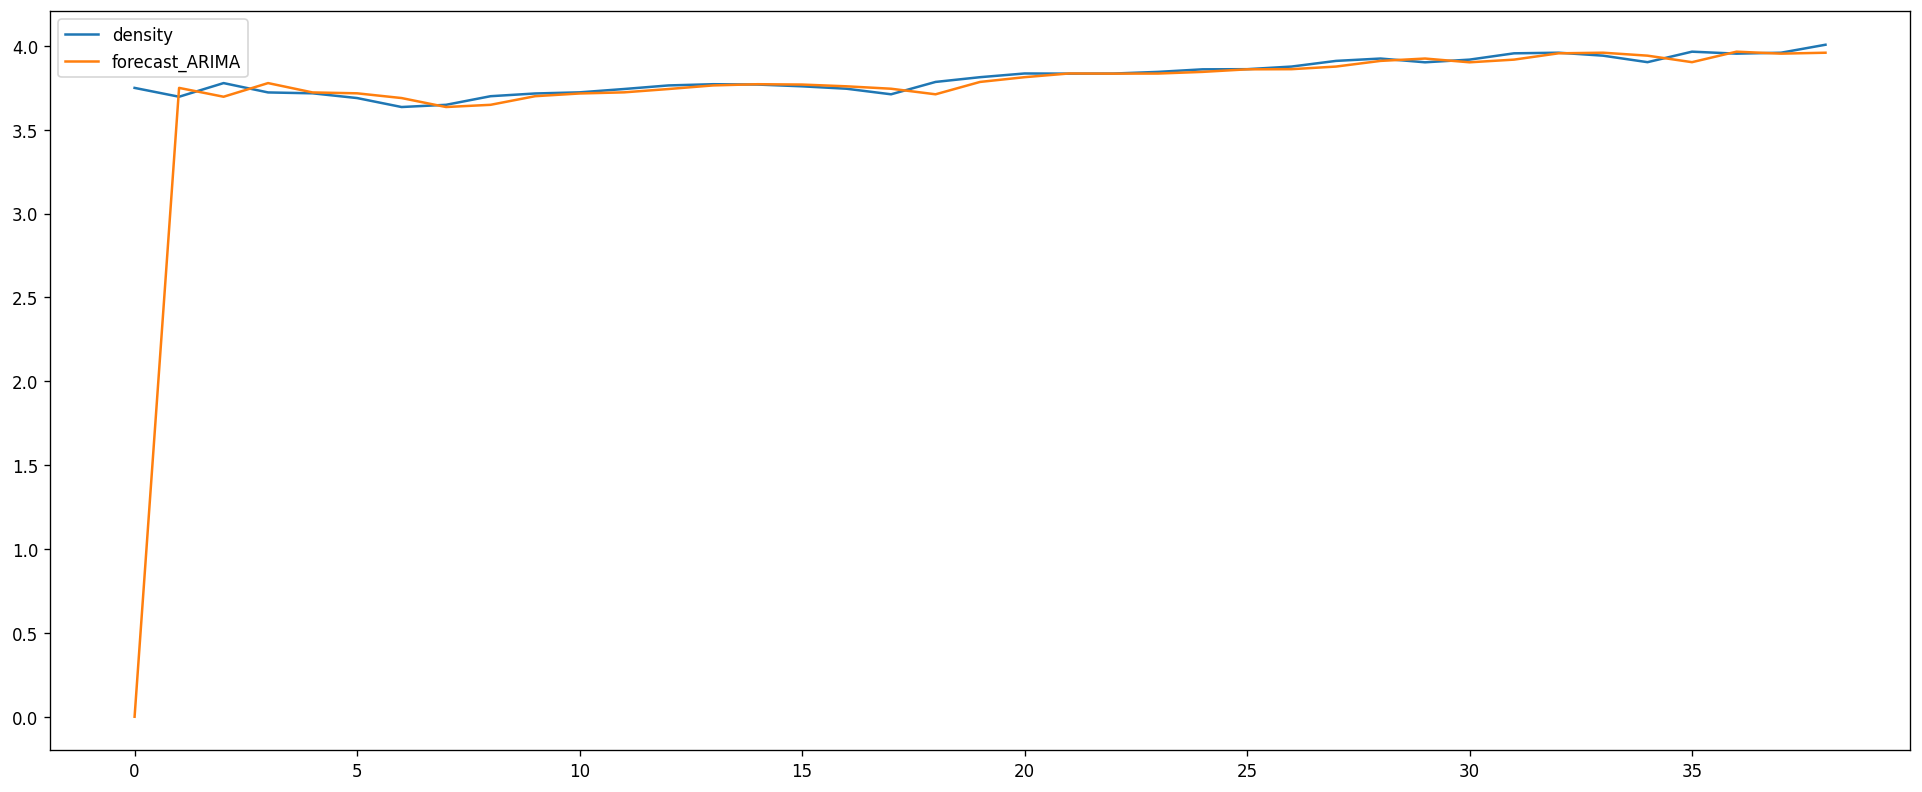

In [25]:

model_ARIMA = ARIMA(df_grouped['density'],
              order=(0,1,0),
              seasonal_order=(0, 0, 0, 0),
            )


model_ARIMA = model_ARIMA.fit()

df_grouped['forecast_ARIMA'] = model_ARIMA.predict()
df_grouped[['density','forecast_ARIMA']].plot(figsize=(20,8))

# Prophet Baseline Model

In Approach 1, we grouped the time-series data by months and didn't account for each individual counties within the Mainland US. We will try to forecast for each county using Prophet.

**Approach 2:** In this approach we will build separate univariate models for each county for 39 months of data.

In [26]:
# Column types
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   row_id                 122265 non-null  object        
 1   cfips                  122265 non-null  int64         
 2   county                 122265 non-null  object        
 3   state                  122265 non-null  object        
 4   first_day_of_month     122265 non-null  datetime64[ns]
 5   microbusiness_density  122265 non-null  float64       
 6   active                 122265 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 6.5+ MB


In [27]:
# Plot the time series for some of the counties 
num_plots = 5
fig = make_subplots(rows=num_plots, cols=1,
                   subplot_titles=(df_train.groupby('cfips').head(1)['cfips'].iloc[:num_plots].to_list()))

for idx, cfip in enumerate(df_train['cfips'].unique()[:num_plots]):
    
    fig.append_trace(go.Scatter(
    x=df_train['first_day_of_month'].loc[df_train['cfips'] == cfip],
    y=df_train['microbusiness_density'].loc[df_train['cfips'] == cfip],
    name=str(df_train['county'].loc[df_train['cfips'] == cfip].tail(1).values[0]) +\
        ', ' + str(df_train['state'].loc[df_train['cfips'] == cfip].tail(1).values[0])    
    ), row=idx+1, col=1)


fig.update_layout(template="simple_white", font=dict(size=18), width=1000, height=1400)
fig.show()

In [28]:
# Prophet requires a dataframe with 'ds': date and 'y': the series
df_train.rename(columns={'first_day_of_month':'ds' }, inplace=True)
df_train.head()

,row_id,cfips,county,state,ds,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [29]:

# We add a small delta to 0's to perform the transformation
df_train['microbusiness_density'].replace({0:0.0000001}, inplace=True)

# Ensure target is names 'y' as prophet requries
df_train['y'], lam = boxcox(df_train['microbusiness_density'])
df_train.head()

,row_id,cfips,county,state,ds,microbusiness_density,active,y
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,1.152025
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,1.106504
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,1.169412
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,1.146759
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,1.146759


### Work in Progres: Prophet Model Training...